## Instalacja pakietów

In [ ]:
%pip install numpy
%pip install pandas
%pip install tqdm
%pip install nltk
%pip install scikit-learn
%pip install matplotlib
%pip install plotly
%pip install seaborn
%pip install pydot
%pip install graphviz
%pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt

In [ ]:
nltk.download("stopwords")
nltk.download('vader_lexicon')
%matplotlib inline
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
pd.options.plotting.backend = "plotly"

Num GPUs Available:  1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [146]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/MyDrive/AGH/MIO')
except:
  print("You are not in colab")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df0 = pd.read_csv("trumptweets.csv")
df = df0[["content", "retweets", "favorites"]].copy()
df

,content,retweets,favorites
0,Be sure to tune in and watch Donald Trump on L...,500,868
1,Donald Trump will be appearing on The View tom...,33,273
2,Donald Trump reads Top Ten Financial Tips on L...,12,18
3,New Blog Post: Celebrity Apprentice Finale and...,11,24
4,"""My persona will never be that of a wallflower...",1399,1965
...,...,...,...
41117,I have never seen the Republican Party as Stro...,32620,213817
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,36239,149571
41119,I was thrilled to be back in the Great State o...,16588,66944
41120,"“In the House, the President got less due proc...",20599,81921


In [ ]:
def tweet_to_words(tweet):
    # convert to lowercase
    text = tweet.lower()
    # remove urls
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "URL", text)
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [ ]:
df["words"] = [tweet_to_words(item) for item in tqdm(df["content"])]
df

100%|██████████| 41122/41122 [01:19<00:00, 520.41it/s]


,content,retweets,favorites,words
0,Be sure to tune in and watch Donald Trump on L...,500,868,"[sure, tune, watch, donald, trump, late, night..."
1,Donald Trump will be appearing on The View tom...,33,273,"[donald, trump, appear, view, tomorrow, morn, ..."
2,Donald Trump reads Top Ten Financial Tips on L...,12,18,"[donald, trump, read, top, ten, financi, tip, ..."
3,New Blog Post: Celebrity Apprentice Finale and...,11,24,"[new, blog, post, celebr, apprentic, final, le..."
4,"""My persona will never be that of a wallflower...",1399,1965,"[persona, never, wallflow, rather, build, wall..."
...,...,...,...,...
41117,I have never seen the Republican Party as Stro...,32620,213817,"[never, seen, republican, parti, strong, unifi..."
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,36239,149571,"[mini, mike, bloomberg, critic, jack, wilson, ..."
41119,I was thrilled to be back in the Great State o...,16588,66944,"[thrill, back, great, state, texa, tonight, pe..."
41120,"“In the House, the President got less due proc...",20599,81921,"[hous, presid, got, less, due, process, 9, 11,..."


In [ ]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = df[label].apply(lambda x: sid.polarity_scores(" ".join(x)))
    df["vader_neg"] = polarity_scores.apply(lambda x: x["neg"])
    df["vader_neu"] = polarity_scores.apply(lambda x: x["neu"])
    df["vader_pos"] = polarity_scores.apply(lambda x: x["pos"])
    df["vader_comp"] = polarity_scores.apply(lambda x: x["compound"])
    df["sentance"] = df[label].apply(lambda x: " ".join(x))
    return df

In [ ]:
df2 = compute_vader_scores(df, "words")
df2

,content,retweets,favorites,words,vader_neg,vader_neu,vader_pos,vader_comp,sentance
0,Be sure to tune in and watch Donald Trump on L...,500,868,"[sure, tune, watch, donald, trump, late, night...",0.000,0.745,0.255,0.4767,sure tune watch donald trump late night david ...
1,Donald Trump will be appearing on The View tom...,33,273,"[donald, trump, appear, view, tomorrow, morn, ...",0.000,0.652,0.348,0.7506,donald trump appear view tomorrow morn discuss...
2,Donald Trump reads Top Ten Financial Tips on L...,12,18,"[donald, trump, read, top, ten, financi, tip, ...",0.000,0.870,0.130,0.2023,donald trump read top ten financi tip late sho...
3,New Blog Post: Celebrity Apprentice Finale and...,11,24,"[new, blog, post, celebr, apprentic, final, le...",0.000,1.000,0.000,0.0000,new blog post celebr apprentic final lesson le...
4,"""My persona will never be that of a wallflower...",1399,1965,"[persona, never, wallflow, rather, build, wall...",0.000,1.000,0.000,0.0000,persona never wallflow rather build wall cling...
...,...,...,...,...,...,...,...,...,...
41117,I have never seen the Republican Party as Stro...,32620,213817,"[never, seen, republican, parti, strong, unifi...",0.000,0.508,0.492,0.7003,never seen republican parti strong unifi right...
41118,Now Mini Mike Bloomberg is critical of Jack Wi...,36239,149571,"[mini, mike, bloomberg, critic, jack, wilson, ...",0.324,0.526,0.150,-0.7650,mini mike bloomberg critic jack wilson save pe...
41119,I was thrilled to be back in the Great State o...,16588,66944,"[thrill, back, great, state, texa, tonight, pe...",0.050,0.433,0.517,0.9325,thrill back great state texa tonight peopl kno...
41120,"“In the House, the President got less due proc...",20599,81921,"[hous, presid, got, less, due, process, 9, 11,...",0.227,0.773,0.000,-0.6908,hous presid got less due process 9 11 terroris...


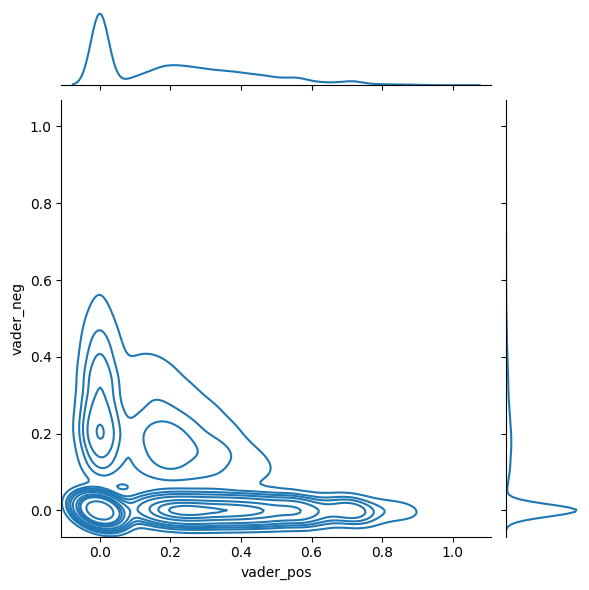

In [ ]:
sns.jointplot(data=df2, x="vader_pos", y="vader_neg", kind="kde");

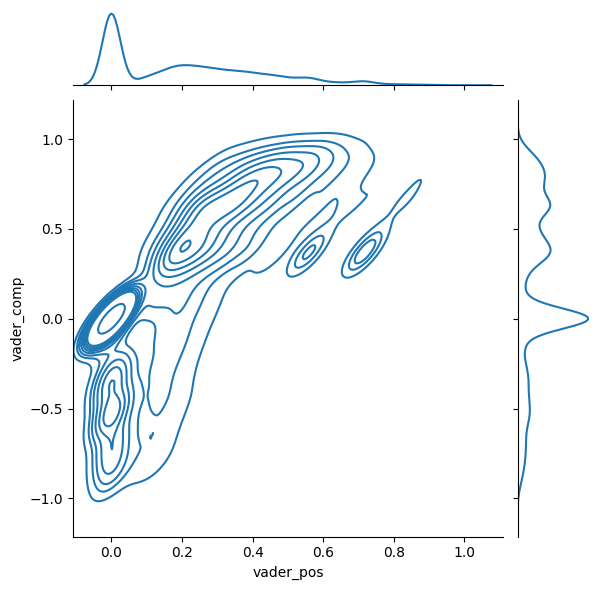

In [ ]:
sns.jointplot(data=df2, x="vader_pos", y="vader_comp", kind="kde");

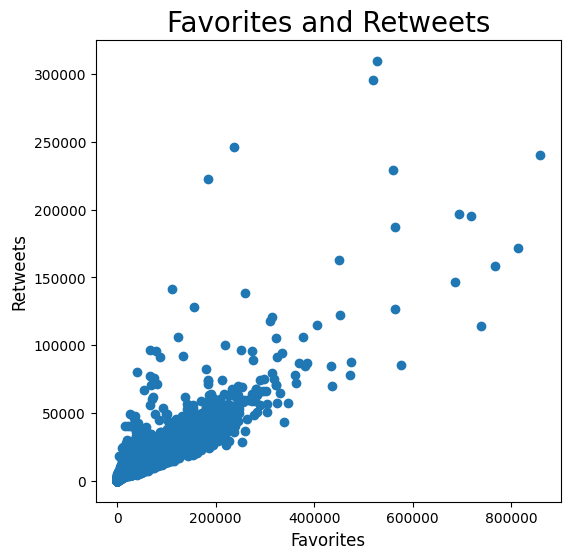

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Favorites and Retweets", fontsize=20)
ax.set_xlabel("Favorites", fontsize=12)
ax.set_ylabel("Retweets", fontsize=12)
ax.scatter(df2.favorites, df2.retweets);

In [ ]:
class0 = []
for i in range(len(df2)):
    if df2.loc[i, "vader_pos"] > 0.1:
        class0 += [2]
    elif df2.loc[i, "vader_neg"] > 0.1:
        class0 += [0]
    else:
        class0 += [1]

In [ ]:
df["class"] = class0
df["class"].value_counts()

2    24694
1    10269
0     6159
Name: class, dtype: int64

In [ ]:
MAX_WORDS = 5000
MAX_LENGTH = 50


def tokenize_pad_sequences(text):
    """
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    """
    # Text tokenization
    tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=" ")
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding="post", maxlen=MAX_LENGTH)
    return X, tokenizer

In [ ]:
print("Before Tokenization & Padding \n", df["sentance"][0])
X, tokenizer = tokenize_pad_sequences(df["sentance"])
print("After Tokenization & Padding \n", X[0])

Before Tokenization & Padding 
 sure tune watch donald trump late night david letterman present top ten list tonight
After Tokenization & Padding 
 [ 284  459   44   17    4  559   88  567  937  925  269 1421  788   76
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
print(X.shape)

(41122, 50)


In [ ]:
y = pd.get_dummies(df["class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

print("Train Set: ", X_train.shape, y_train.shape)
print("Validation Set: ", X_val.shape, y_val.shape)
print("Test Set: ", X_test.shape, y_test.shape)

Train Set:  (24672, 50) (24672, 3)
Validation Set:  (8225, 50) (8225, 3)
Test Set:  (8225, 50) (8225, 3)


In [ ]:
import tensorflow.keras.backend as K


def f1_score(precision, recall):
    """Function to calculate f1 score"""

    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

## Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate, decay_steps=10000, decay_rate=0.9
)

In [ ]:
sgd = SGD(learning_rate=lr_schedule, momentum=momentum, nesterov=False)
# Build model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=MAX_LENGTH))
model.add(Conv1D(filters=32, kernel_size=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation="softmax"))

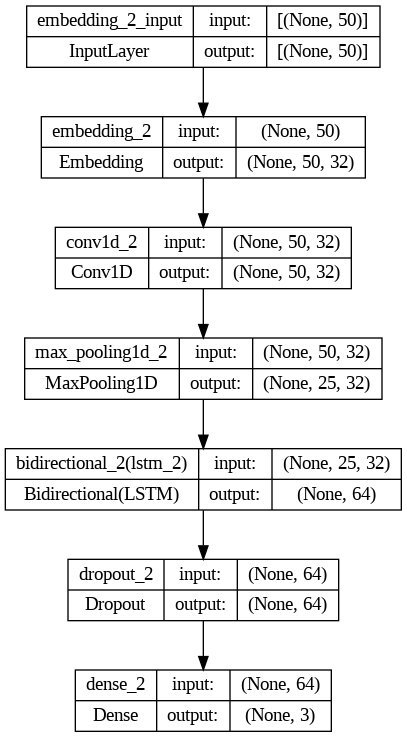

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=sgd,
    metrics=["accuracy", Precision(), Recall()],
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=epochs,
    verbose=1,
)

Epoch 1/10
386/386 [==============================] - 14s 27ms/step - loss: 0.8371 - accuracy: 0.6417 - precision_2: 0.6631 - recall_2: 0.5947 - val_loss: 0.4460 - val_accuracy: 0.8184 - val_precision_2: 0.8922 - val_recall_2: 0.7424
Epoch 2/10
386/386 [==============================] - 4s 10ms/step - loss: 0.3401 - accuracy: 0.8704 - precision_2: 0.8935 - recall_2: 0.8453 - val_loss: 0.2141 - val_accuracy: 0.9353 - val_precision_2: 0.9360 - val_recall_2: 0.9329
Epoch 3/10
386/386 [==============================] - 3s 9ms/step - loss: 0.1872 - accuracy: 0.9452 - precision_2: 0.9481 - recall_2: 0.9424 - val_loss: 0.1621 - val_accuracy: 0.9551 - val_precision_2: 0.9580 - val_recall_2: 0.9517
Epoch 4/10
386/386 [==============================] - 3s 9ms/step - loss: 0.1442 - accuracy: 0.9601 - precision_2: 0.9625 - recall_2: 0.9572 - val_loss: 0.1554 - val_accuracy: 0.9561 - val_precision_2: 0.9579 - val_recall_2: 0.9547
Epoch 5/10
386/386 [==============================] - 4s 9ms/step - l

## Evaluation

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy  : {:.4f}".format(accuracy))
print("Precision : {:.4f}".format(precision))
print("Recall    : {:.4f}".format(recall))
print("F1 Score  : {:.4f}".format(f1_score(precision, recall)))

Accuracy  : 0.9576
Precision : 0.9585
Recall    : 0.9568
F1 Score  : 0.9577


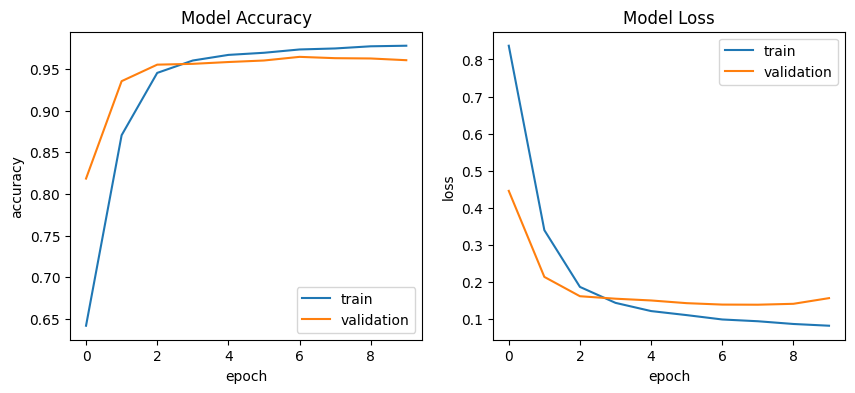

In [ ]:
def plot_training_hist(history):
    """Function to plot history for accuracy and loss"""

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # first plot
    ax[0].plot(history.history["accuracy"])
    ax[0].plot(history.history["val_accuracy"])
    ax[0].set_title("Model Accuracy")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("accuracy")
    ax[0].legend(["train", "validation"], loc="best")

    # second plot
    ax[1].plot(history.history["loss"])
    ax[1].plot(history.history["val_loss"])
    ax[1].set_title("Model Loss")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("loss")
    ax[1].legend(["train", "validation"], loc="best")


plot_training_hist(history)

258/258 [==============================] - 1s 3ms/step
2    4890
1    2080
0    1255
dtype: int64
2    4869
1    2204
0    1152
dtype: int64


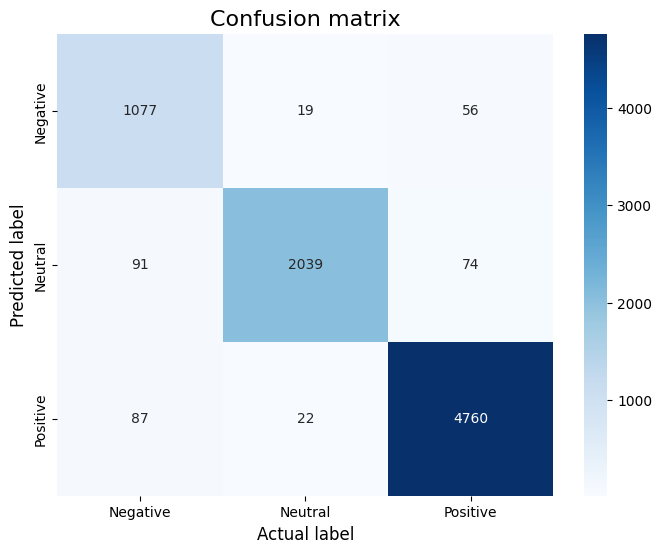

In [ ]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X_test, y_test):
    """Function to plot confusion matrix for the passed model and the data"""

    sentiment_classes = ["Negative", "Neutral", "Positive"]
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(
        np.argmax(y_pred, axis=1), np.argmax(np.array(y_test), axis=1)
    )

    print(pd.Series(np.argmax(np.array(y_test), axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        cmap=plt.cm.Blues,
        annot=True,
        fmt="d",
        xticklabels=sentiment_classes,
        yticklabels=sentiment_classes,
    )
    plt.title("Confusion matrix", fontsize=16)
    plt.xlabel("Actual label", fontsize=12)
    plt.ylabel("Predicted label", fontsize=12)


plot_confusion_matrix(model, X_test, y_test)

In [ ]:
import pickle

with open("models/trump_tweets_model_v1.pkl", "wb") as f:
    pickle.dump(model, f)

isExist = os.path.exists("data")
if not isExist:
   os.makedirs("data")

pd.DataFrame(X_train).to_pickle("data/X_train.pkl")
pd.DataFrame(y_train).to_pickle("data/Y_train.pkl")
pd.DataFrame(X_test).to_pickle("data/X_test.pkl")
pd.DataFrame(y_test).to_pickle("data/Y_test.pkl")

# Shap

In [ ]:
import shap

4/4 [==============================] - 0s 4ms/step
Text: watch video ivanka trump share busi advic 4 entrepreneuri women gma url
Word index: [  44  506 1126    4 1211  106  857  264 3899  356 2649    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


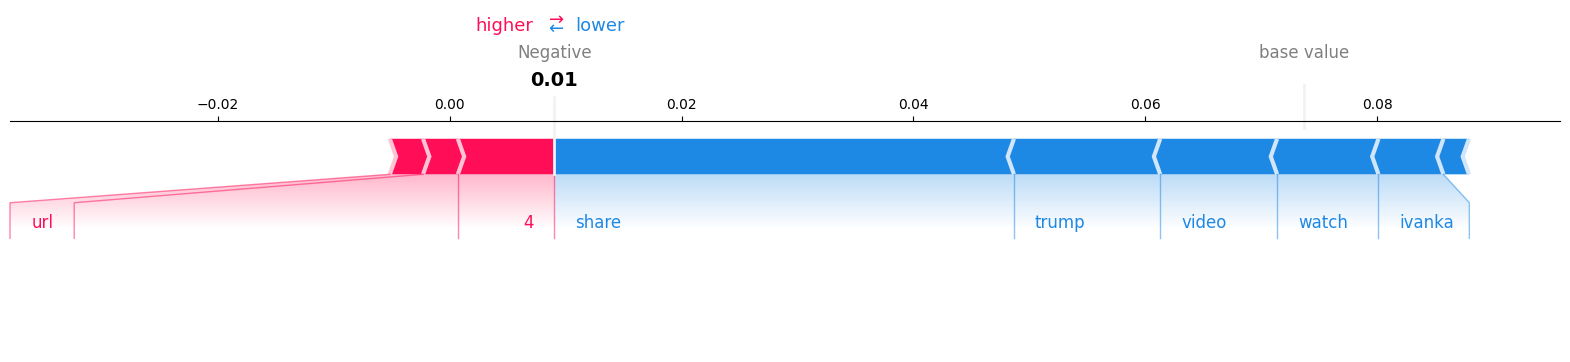

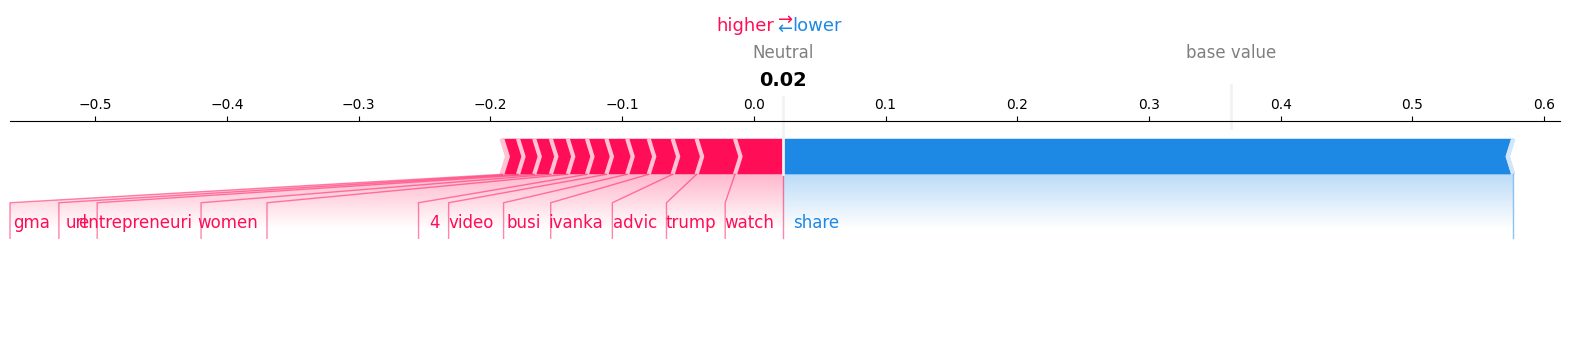

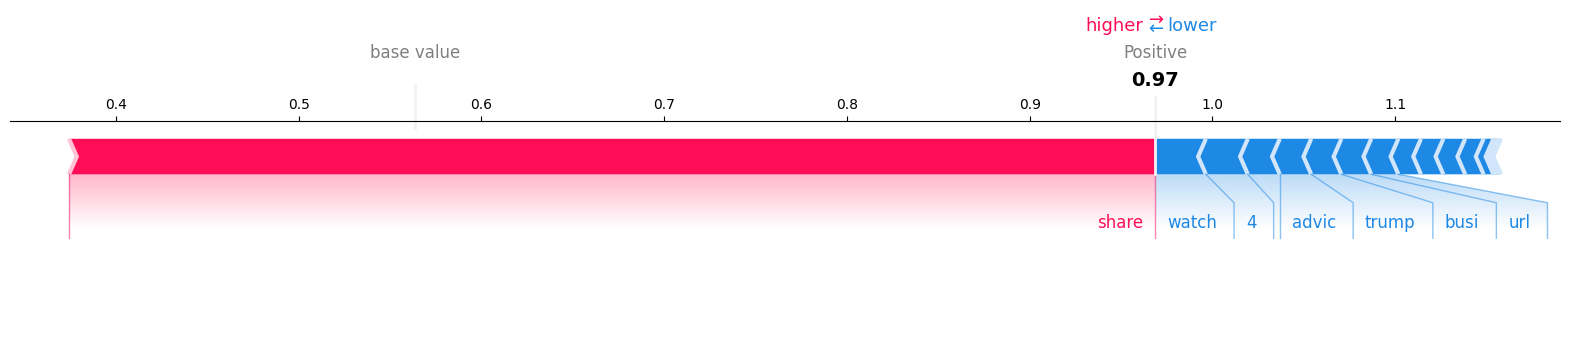

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(model, X[:100, :])
predictions = model.predict(X[:100, :])

sample_id = 48

text = df["sentance"][sample_id]
words = text.split()
sample = X[sample_id]

print(f"Text: {text}")
print(f"Word index: {sample}")
shap_values = explainer.shap_values(sample, nsamples=500)

features = [
    words[index] if value != 0 else "" for index, value in enumerate(sample)
]

for i in range(len(shap_values)):
    sample_v = shap_values[i]
    shap.force_plot(
        explainer.expected_value[i],
        sample_v,
        features=features,
        out_names=["Negative", "Neutral", "Positive"][i],
        matplotlib=True,
    )

['watch', 'video', 'ivanka', 'trump', 'share', 'busi', 'advic', '4', 'entrepreneuri', 'women', 'gma', 'url', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


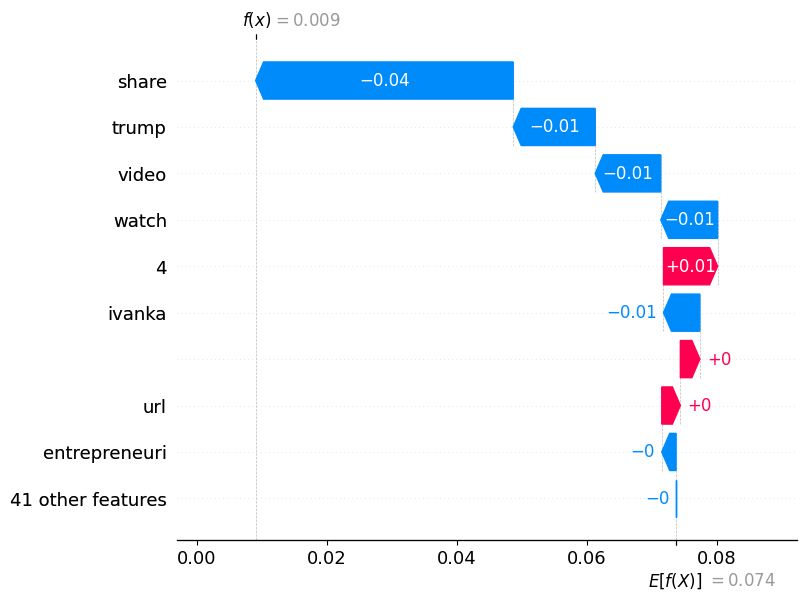

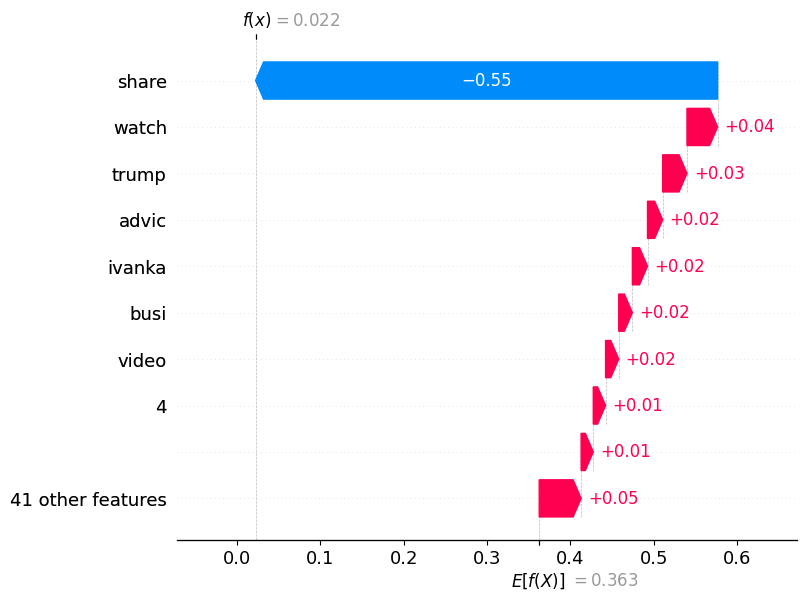

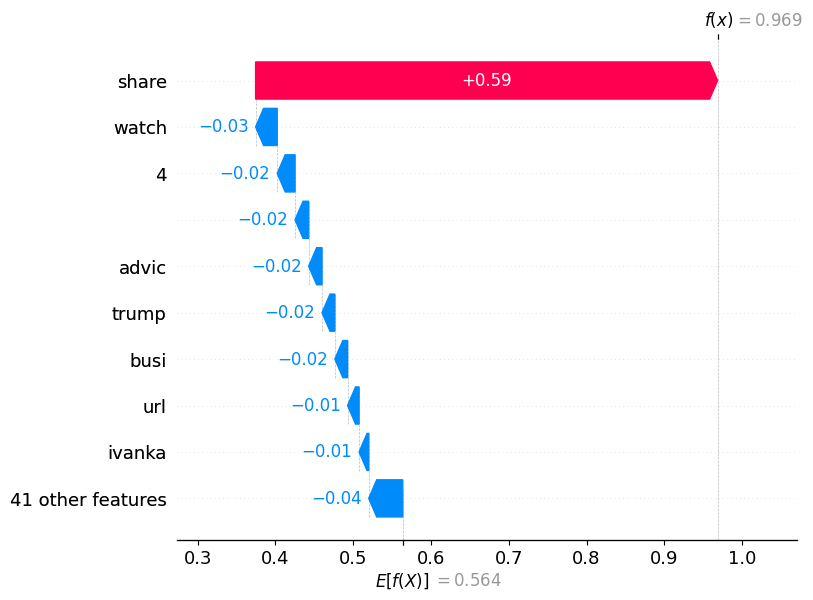

In [ ]:
import shap_fixes
print(features)

for i in range(3):
    shap_fixes.waterfall_legacy(
        explainer.expected_value[i], shap_values[i], feature_names=features
    )

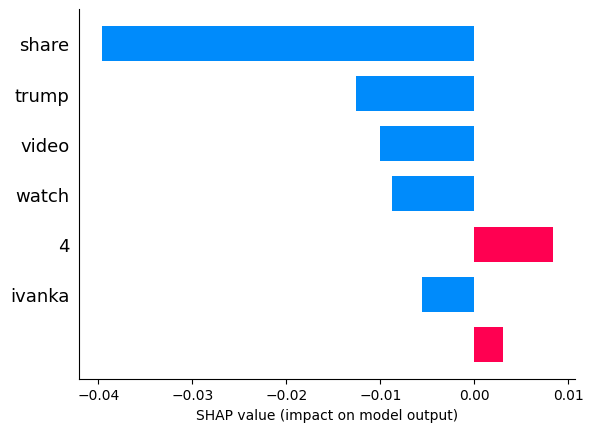

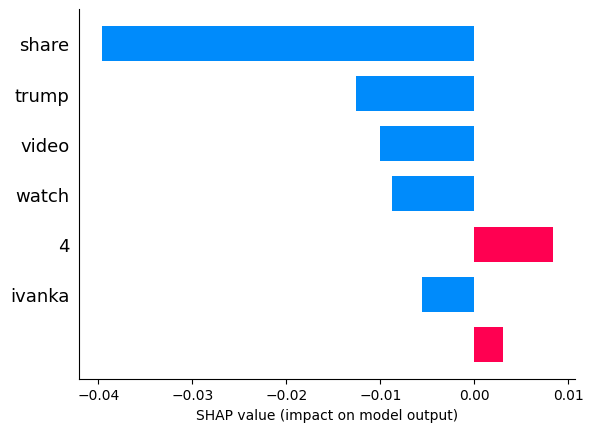

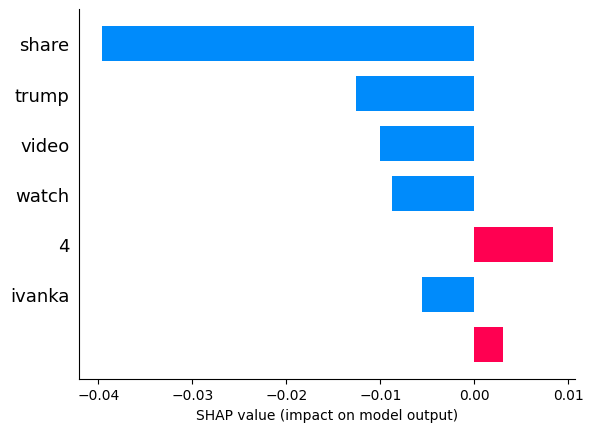

In [ ]:
for i in range(3):
    shap.bar_plot(shap_values[0], feature_names=features)

In [ ]:
shap_values_50 = explainer.shap_values(X[:50], nsamples=500)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
np.array(shap_values_50).shape

(3, 50, 50)

In [ ]:
np.array(shap_values_50)[:, :, :].shape

(3, 50, 50)

In [ ]:
features_50 = np.array(
    [
        [
            df["sentance"][i].split()[index] if value != 0 else ""
            for index, value in enumerate(X[i])
        ]
        for i in range(50)
    ]
)

In [ ]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values_50[0],
    features=features_50,
    out_names=["Negative", "Neutral", "Positive"][0],
)

In [ ]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    shap_values_50[1],
    features=features_50,
    out_names=["Negative", "Neutral", "Positive"][1],
)

In [ ]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[2],
    shap_values_50[2],
    features=features_50,
    out_names=["Negative", "Neutral", "Positive"][2],
)

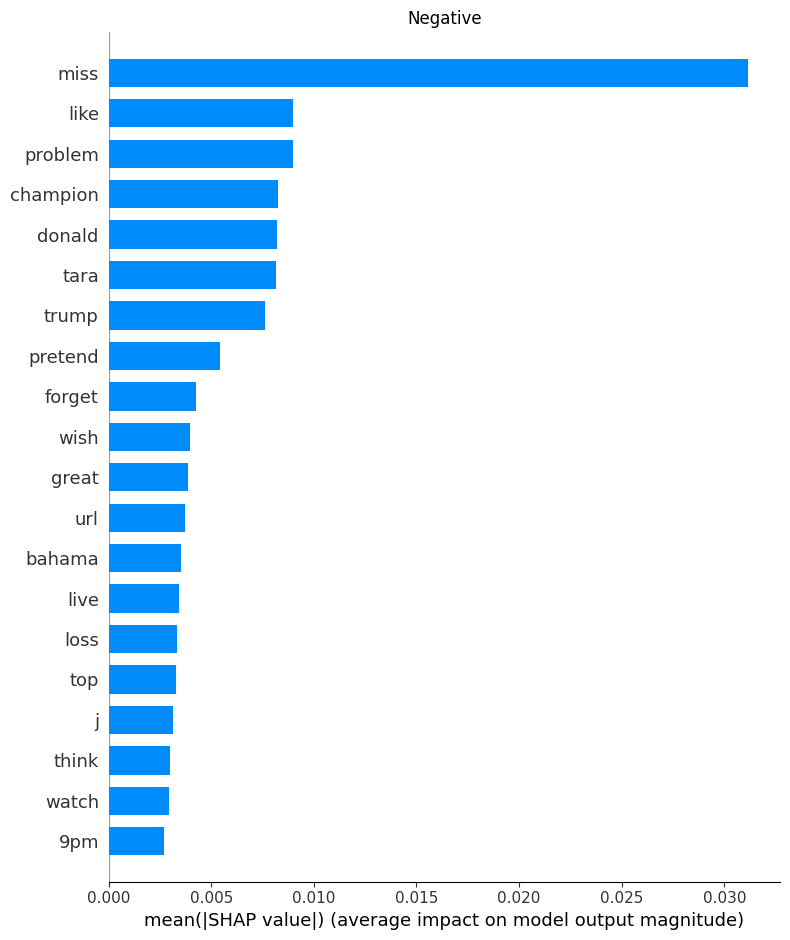

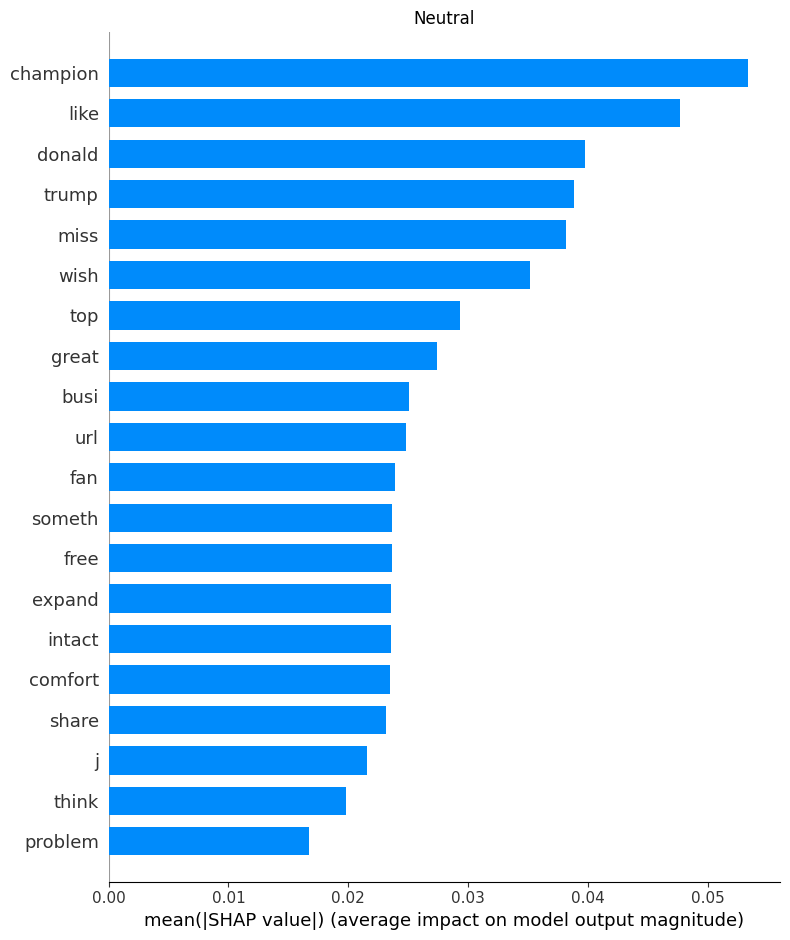

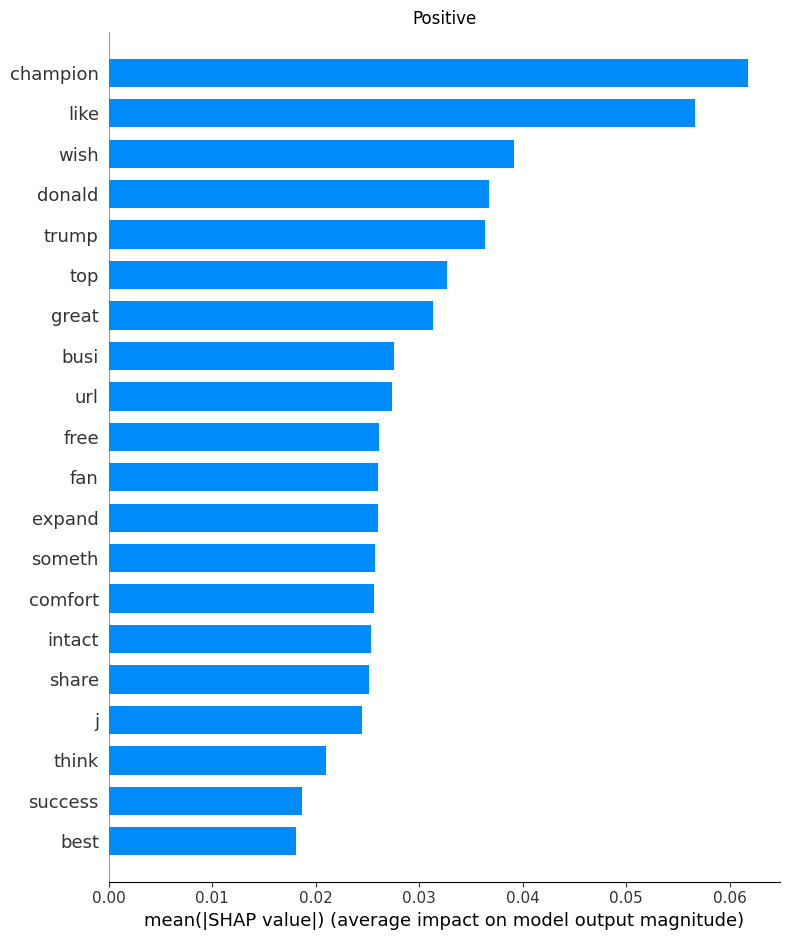

In [ ]:
def run_plots():
    for var in range(3):
        shap_values_test = np.hstack(shap_values_50[var])
        sample_fn_test = features_50.reshape(-1, 1)
        id = []

        for word in np.unique(sample_fn_test):
            id.append(np.unique(np.where(sample_fn_test == word)))

        sample_len = max(map(lambda x: len(x), id[1:]))
        feature_len = len(np.unique(sample_fn_test)) - 1
        feature_names_test = np.unique(sample_fn_test)[1:]

        new_sv = np.zeros((feature_len, sample_len))
        for i in range(1, len(id) - 1):
            for y in id[i]:
                x = np.where(new_sv[i - 1] == 0)[0][0]
                new_sv[i - 1][x] = shap_values_test[y]
        new_sv = np.transpose(new_sv)
        # plt.title(["Negative", "Neutral", "Positive"][var])
        # func(new_sv, feature_names_test, **kwargs)
        yield new_sv, feature_names_test, sample_len, feature_len, var
        # shap.summary_plot(new_sv, feature_names_test, plot_type='bar',  class_names=["Negative", "Neutral", "Positive"])


[
    (
        plt.title(["Negative", "Neutral", "Positive"][var]),
        shap.summary_plot(
            new_sv,
            feature_names_test,
            plot_type="bar",
            class_names=["Negative", "Neutral", "Positive"],
        ),
    )
    for new_sv, feature_names_test, sample_len, feature_len, var in run_plots()
];

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


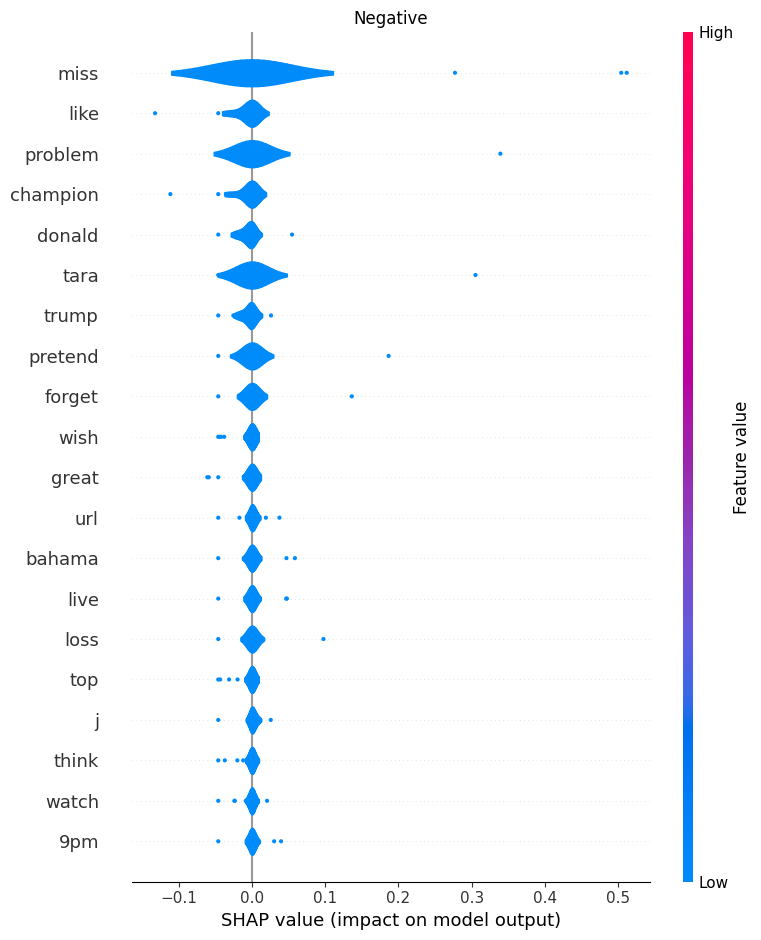

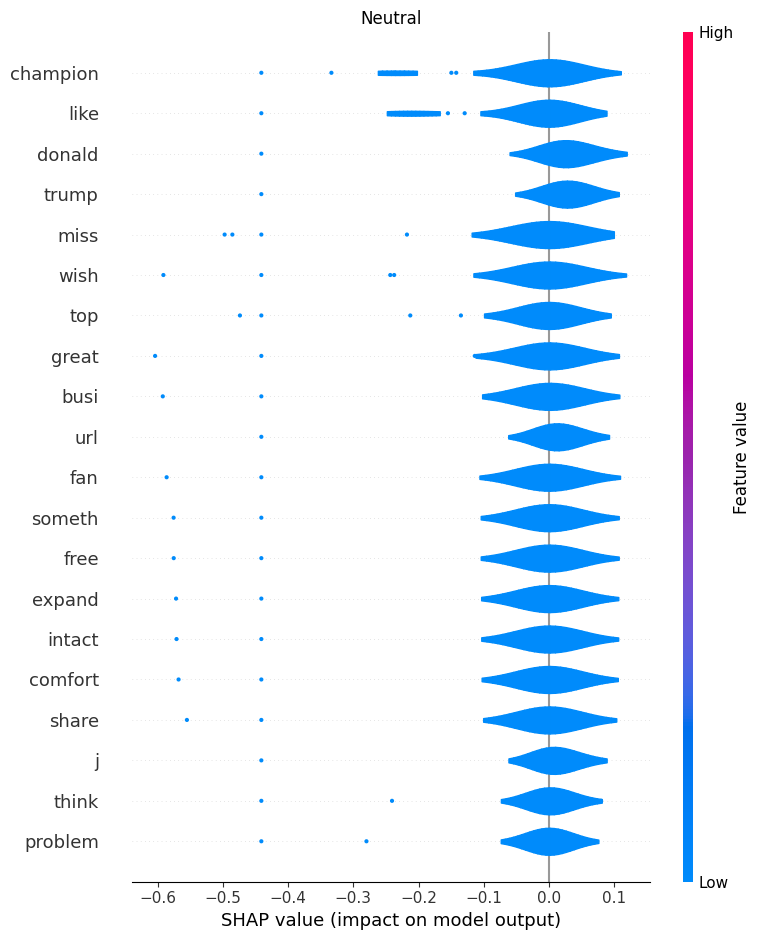

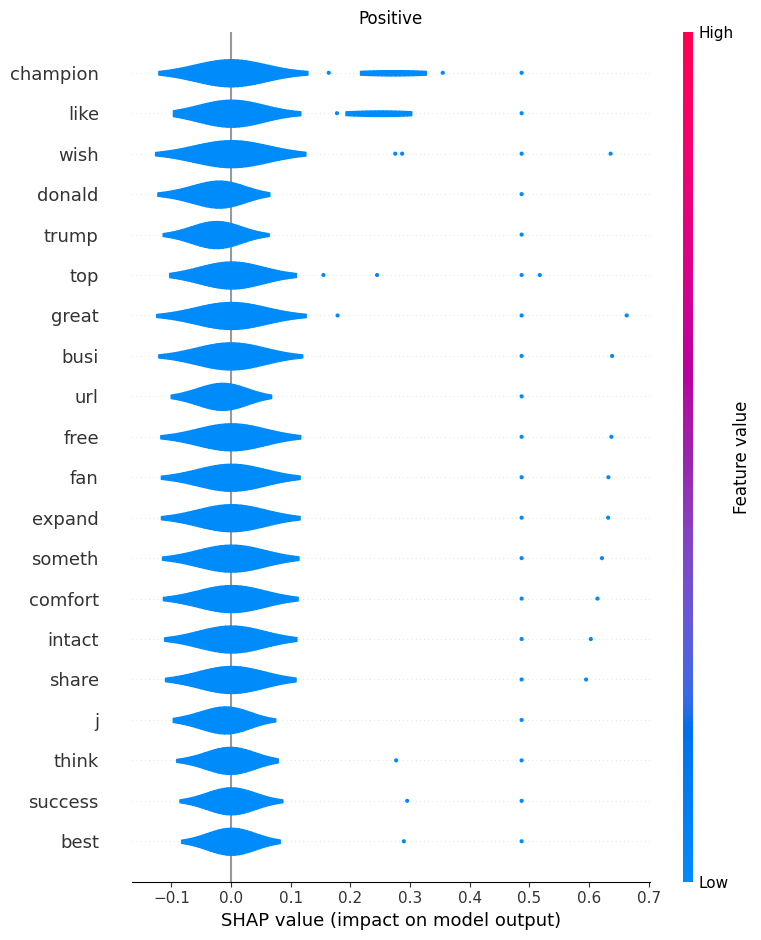

In [ ]:
[
    (
        plt.title(["Negative", "Neutral", "Positive"][var]),
        shap.summary_plot(
            new_sv,
            pd.DataFrame([list(range(feature_len)) for _ in range(sample_len)]),
            feature_names=feature_names_test,
            plot_type="violin",
        ),
    )
    for new_sv, feature_names_test, sample_len, feature_len, var in run_plots()
];

In [ ]:
print(features_50.shape)

(50, 50)


not enough data in bin #1 for feature Tweet #14, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature Tweet #14, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #3 for feature Tweet #14, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #1 for feature Tweet #13, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature Tweet #13, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #3 for feature Tweet #13, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #4 for feature Tweet #13, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #5 for feature Tweet #13, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature Tweet #11, so it'll be ignored. Tr

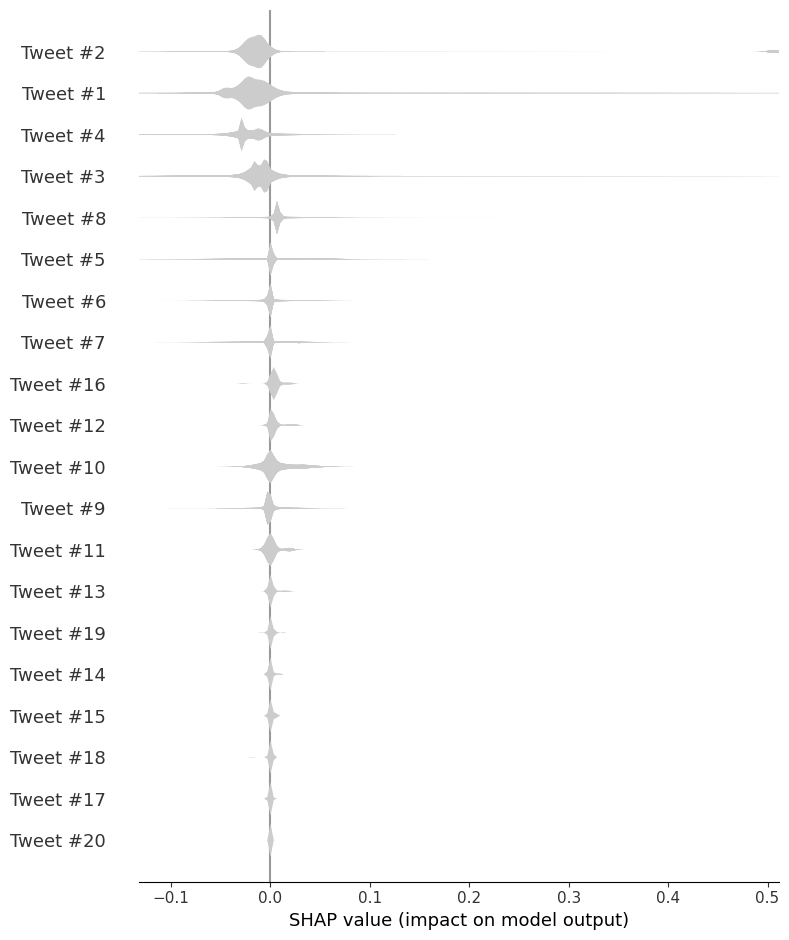

In [ ]:
shap.summary_plot(
    np.array(shap_values_50)[0],
    X[:50],
    feature_names=[f"Tweet #{i+1}" for i in range(50)],
    plot_type="layered_violin",
    class_names=["1", "2", "3"],
    color="#cccccc",
)

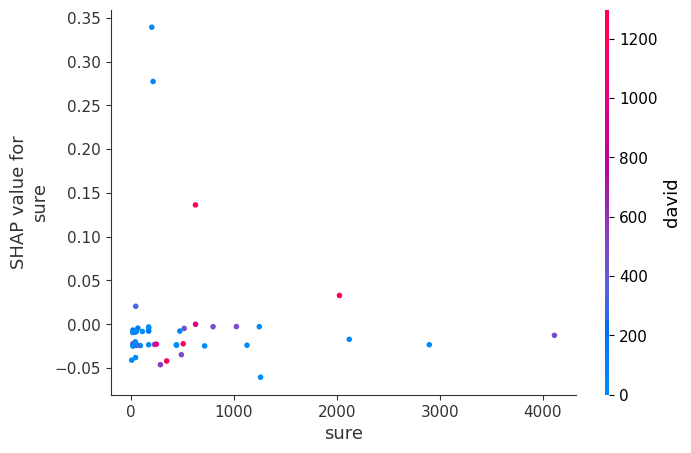

In [ ]:
shap.dependence_plot(
    0, np.array(shap_values_50)[0], X[:50], feature_names=features_50[0]
)